In [4]:
import numpy as np
import sklearn
import time
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import cv2

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

In [5]:
feat_path_full = '/kaggle/input/mfcc-new/mfcc_features.npy'
labels_path_full = '/kaggle/input/mfcc-new/mfcc_labels.npy'

features = np.load(feat_path_full)
labels = np.load(labels_path_full)

In [6]:
labels = label_binarize(labels, classes=['Negative', 'Positive'])

print(features.shape)
print(labels.shape)

(9205, 13, 422)
(9205, 1)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=1)
X_train = X_train.reshape(X_train.shape[0], -1, 13)
X_val = X_val.reshape(X_val.shape[0], -1, 13)
X_test = X_test.reshape(X_test.shape[0], -1, 13)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(7364, 422, 13)
(7364, 1)
(920, 422, 13)
(920, 1)
(921, 422, 13)
(921, 1)


In [8]:
# Concatenate labeled and unlabeled data
X_all = np.concatenate((X_train, X_val, X_test), axis=0)
y_all = np.concatenate((y_train, y_val, y_test), axis=0)

In [9]:
# Define the consistency loss function
def consistency_loss(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

In [10]:
num_folds = 10
fold_no = 1

loss_per_fold = []
acc_per_fold = []
precision_per_fold = []
recall_per_fold = []
auc_per_fold = []
histories = []

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC')
]

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=123)

In [11]:
for train, test in kfold.split(X_train, y_train):
    # Hyperparameter definition
    epochs = 30
    batch_size = 128
    learning_rate = 0.001
    filepath = "model_best_weights_" + str(fold_no) + ".hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    # Model architecture
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    inputs = keras.Input(shape=(422, 13))
    x = inputs
    x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Conv1D(filters=128, kernel_size=5, activation="relu")(x)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    student_net = keras.Model(inputs, outputs)
    
    teacher_net = keras.models.clone_model(student_net)
    teacher_net.set_weights(student_net.get_weights())

    student_net.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

    # Train the model with consistency regularization
    history = student_net.fit(
        X_train[train],
        y_train[train],
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[checkpoint],
    )
    
    histories.append(history)
    
    # Load the best weights saved by the checkpoint
    student_net.load_weights(filepath)
    
    # Evaluate the model on the validation set
    val_scores = student_net.evaluate(X_train[test], y_train[test], verbose=0)
    print("Validation results for fold " + str(fold_no) + ":")
    print("Accuracy:", val_scores[1])
    print("Precision:", val_scores[2])
    print("Recall:", val_scores[3])
    print("ROC AUC:", val_scores[4])
    
    # Evaluate the model on the test set
    test_scores = student_net.evaluate(X_test, y_test, verbose=0)
    print("Test results for fold " + str(fold_no) + ":")
    print("Accuracy:", test_scores[1])
    print("Precision:", test_scores[2])
    print("Recall:", test_scores[3])
    print("ROC AUC:", test_scores[4])
    
    loss_per_fold.append(test_scores[0])
    acc_per_fold.append(test_scores[1])
    precision_per_fold.append(test_scores[2])
    recall_per_fold.append(test_scores[3])
    auc_per_fold.append(test_scores[4])
    
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
52/52 [==============================] - ETA: 0s - loss: 5.3817 - accuracy: 0.6203 - precision: 0.3338 - recall: 0.2490 - AUC: 0.5347
Epoch 1: val_accuracy improved from -inf to 0.70000, saving model to model_best_weights_1.hdf5
52/52 [==============================] - 11s 30ms/step - loss: 5.3817 - accuracy: 0.6203 - precision: 0.3338 - recall: 0.2490 - AUC: 0.5347 - val_loss: 0.6158 - val_accuracy: 0.7000 - val_precision: 0.7273 - val_recall: 0.0285 - val_AUC: 0.5670
Epoch 2/30
48/52 [==========================>...] - ETA: 0s - loss: 0.5837 - accuracy: 0.7147 - precision: 0.5997 - recall: 0.2002 - AUC: 0.6699
Epoch 2: val_accuracy improved from 0.70000 to 0.70543, saving model to model_best_weights_1.hdf5
52/52 [==============================] - 1s 12ms/step - loss: 0.5817 - accuracy: 0.7160 - precision: 0.5994 - recall: 0.2004 - AUC: 0.6703 - val_loss: 0.5921 - val_accuracy: 0

In [12]:
teacher_net.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 422, 13)]         0         
                                                                 
 conv1d_18 (Conv1D)          (None, 418, 64)           4224      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 139, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 135, 128)          41088     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 45, 128)          0         
 g1D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 5760)              0   

In [13]:
# Calculate average metrics
mean_loss = np.mean(loss_per_fold)
mean_acc = np.mean(acc_per_fold)
mean_precision = np.mean(precision_per_fold)
mean_recall = np.mean(recall_per_fold)
mean_auc = np.mean(auc_per_fold)

In [14]:
# Print the average evaluation metrics across all folds
print("\nAverage metrics:")
print("Loss: {:.4f}".format(mean_loss))
print("Accuracy: {:.2f}%".format(mean_acc * 100))
print("Precision: {:.2f}%".format(mean_precision * 100))
print("Recall: {:.2f}%".format(mean_recall * 100))
print("AUC: {:.2f}%".format(mean_auc * 100))


Average metrics:
Loss: 0.6842
Accuracy: 88.46%
Precision: 87.39%
Recall: 72.78%
AUC: 88.55%


Text(0, 0.5, 'Recall')

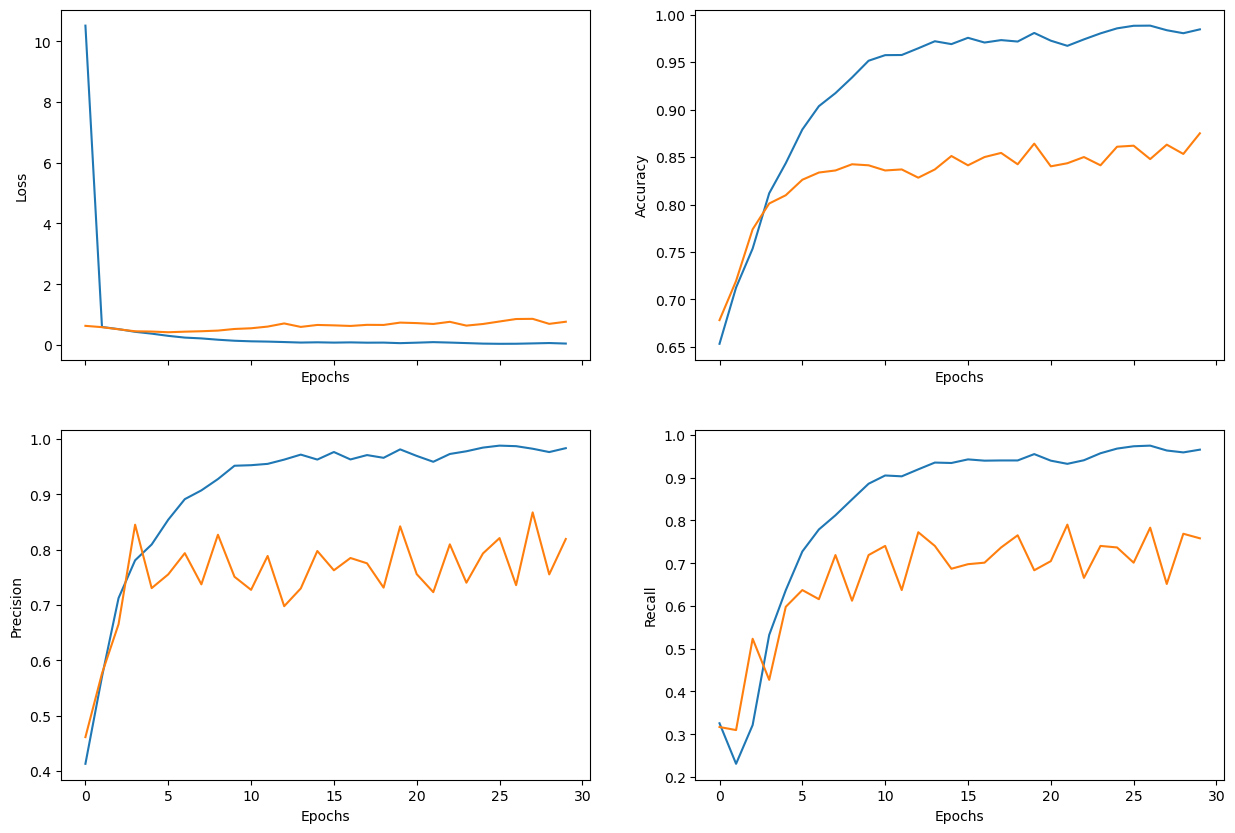

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(15,10), sharex=True)
ax[0, 0].plot(histories[6].history['loss'])
ax[0, 0].plot(histories[6].history['val_loss'])
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
###########################################
ax[0, 1].plot(histories[6].history['accuracy'])
ax[0, 1].plot(histories[6].history['val_accuracy'])
ax[0, 1].set_xlabel('Epochs')
ax[0, 1].set_ylabel('Accuracy')
###########################################
ax[1, 0].plot(histories[6].history['precision'])
ax[1, 0].plot(histories[6].history['val_precision'])
ax[1, 0].set_xlabel('Epochs')
ax[1, 0].set_ylabel('Precision')
###########################################
ax[1, 1].plot(histories[6].history['recall'])
ax[1, 1].plot(histories[6].history['val_recall'])
ax[1, 1].set_xlabel('Epochs')
ax[1, 1].set_ylabel('Recall')

[0.5668341517448425, 0.8914223909378052, 0.902222216129303, 0.7224199175834656, 0.8895684480667114]
29/29 [==============================] - 0s 2ms/step


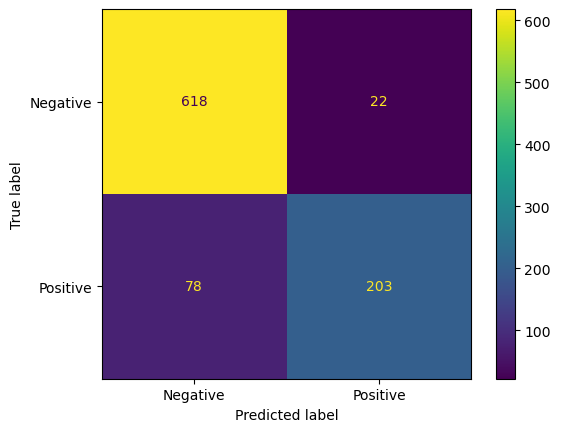

In [30]:
# Load best model
model_path = '/kaggle/working/model_best_weights_5.hdf5'
model_1 = load_model(model_path)

scores = model_1.evaluate(X_test, y_test, verbose=0)
print(scores)

# Performance on test
COVIDpred = model_1.predict(X_test)
COVIDpred = np.where(COVIDpred >= 0.5, 1, 0)

cm = confusion_matrix(y_test, COVIDpred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=('Negative', 'Positive'))
disp.plot()

In [ ]:
## Concatenate all predictions and true labels from each fold
all_predictions = []
all_true_labels = []

for fold_no, (train, test) in enumerate(kfold.split(X_train, y_train)):
    model_path = 'model_best_weights_' + str(fold_no + 1) + '.hdf5'
    model = load_model(model_path)

    # Get predictions for test set
    fold_predictions = model.predict(X_train[test])

    all_predictions.append(fold_predictions)
    all_true_labels.append(y_train[test])

In [18]:
# Concatenate predictions and true labels from all folds
all_predictions = np.concatenate(all_predictions)
all_true_labels = np.concatenate(all_true_labels)

In [19]:
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(all_true_labels, all_predictions)
roc_auc = auc(fpr, tpr)

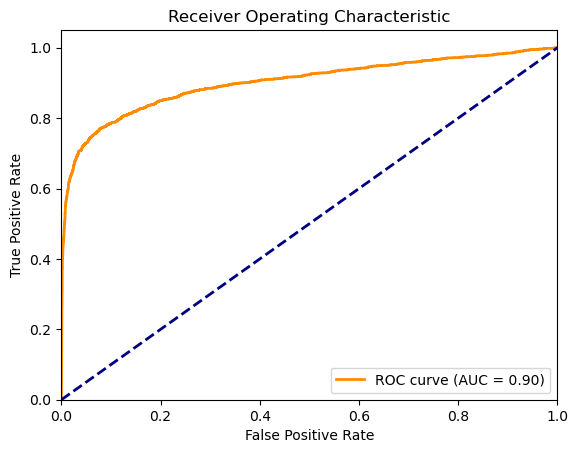

In [20]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()